<a href="https://colab.research.google.com/github/Ganesh-Kdt/Assignment-2-NN/blob/neural_network_part2/Assignment_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# #load the dataset through drive
# from google.colab import drive
# drive.mount('/content/drive')

df = pd.read_csv('dataset.csv')
df.head()
print(df.shape)

(766, 8)


In [2]:
#describe function to describe the statistics such as mean,min,max,std for each feature in our dataset
df.info()
df=df.apply(pd.to_numeric,errors='coerce')
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 766 entries, 0 to 765
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   f1      766 non-null    object
 1   f2      766 non-null    object
 2   f3      766 non-null    int64 
 3   f4      766 non-null    object
 4   f5      766 non-null    object
 5   f6      766 non-null    object
 6   f7      766 non-null    object
 7   target  766 non-null    int64 
dtypes: int64(2), object(6)
memory usage: 48.0+ KB


,f1,f2,f3,f4,f5,f6,f7,target
count,765.000000,765.000000,766.000000,765.000000,765.000000,765.000000,765.000000,766.000000
mean,3.849673,120.909804,69.118799,20.542484,80.091503,31.998170,0.472128,0.349869
std,3.373696,31.947945,19.376901,15.960515,115.374383,7.898275,0.331545,0.477240
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,0.000000
25%,1.000000,99.000000,62.500000,0.000000,0.000000,27.300000,0.244000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,36.000000,32.000000,0.374000,0.000000
75%,6.000000,140.000000,80.000000,32.000000,128.000000,36.600000,0.626000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,1.000000


In [5]:
#to replace NA values with median values
for column in df.columns:
    if df[column].isna().any():
          df[column] = df[column].fillna(df[column].median())

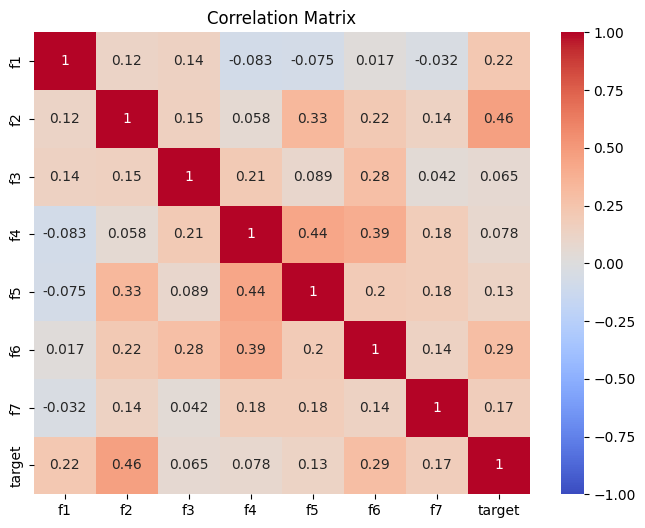

<Figure size 1200x800 with 0 Axes>

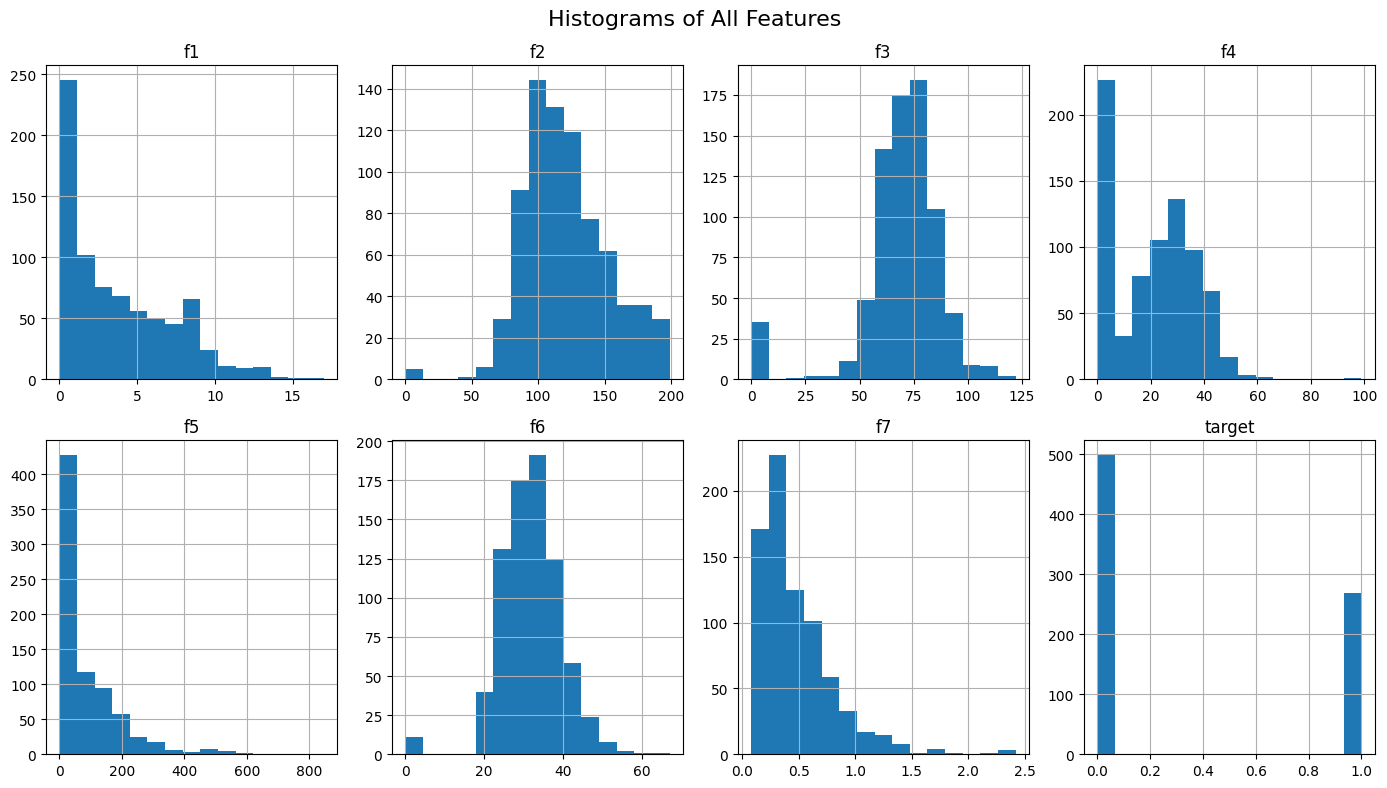

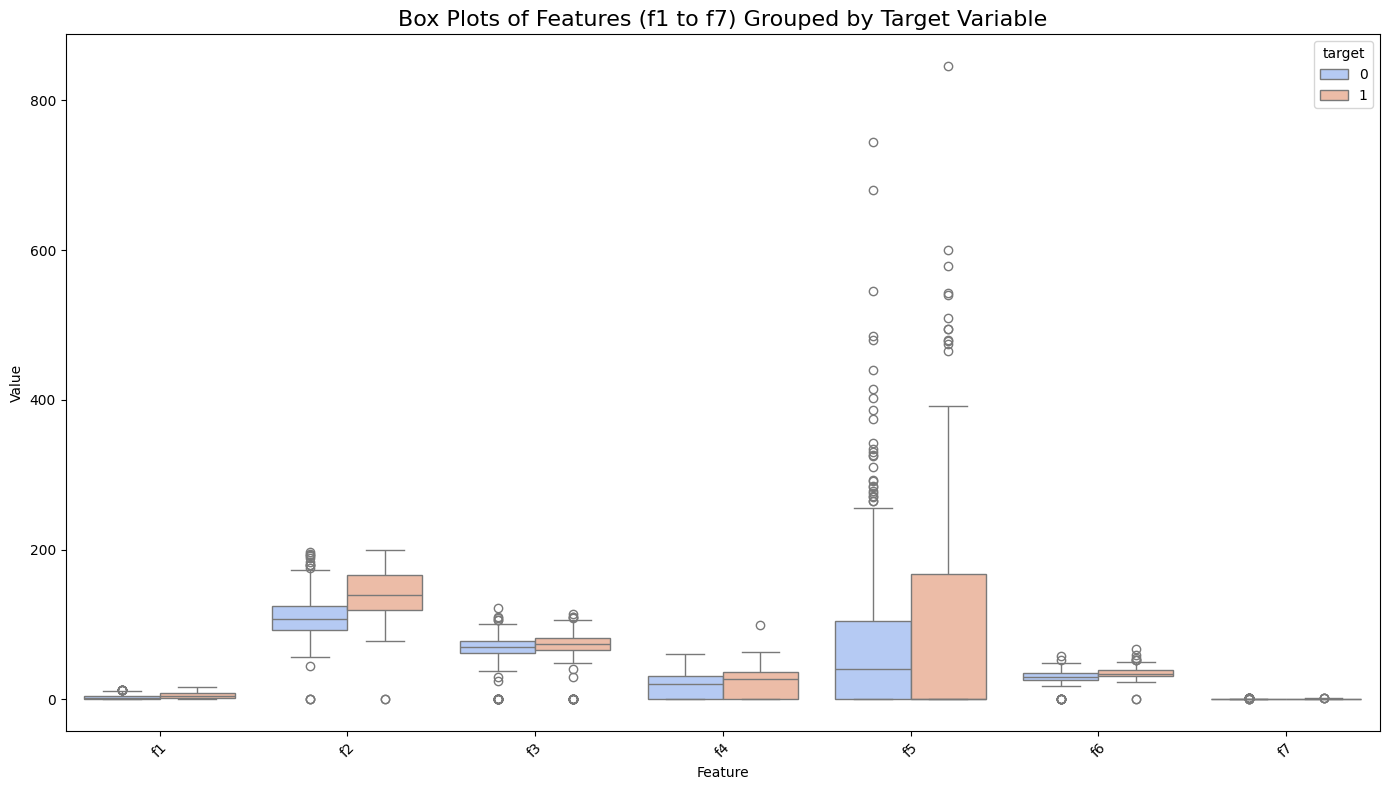

In [6]:
#1 - Correlation Matrix shows the correlation between our 7 features and the target variable.
corelation_matrix = df.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corelation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

#2 - Histogram representing the range of values for each features.
plt.figure(figsize=(12, 8))
df.hist(bins=15, figsize=(14, 8), layout=(2, 4))
plt.suptitle('Histograms of All Features', fontsize=16)
plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 8))
df_melted = pd.melt(df, id_vars='target', value_vars=['f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], var_name='Feature', value_name='Value')
sns.boxplot(x='Feature', y='Value', hue='target', data=df_melted, palette='coolwarm')
plt.title('Box Plots of Features (f1 to f7) Grouped by Target Variable', fontsize=16)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [5]:
pip install imbalanced-learn

In [24]:
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

#we are removing features f3,f4,f5 as they have very little impact on our target variable which can be observed in the correlation martrix.
X = df.drop(columns=['target','f3','f4','f5'])
y = df['target']
print(df['target'].value_counts())

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
# Splitting the dataset into 70% training, 15% validation, 15% testing
X_train_val, X_test, Y_train_val, Y_test = train_test_split(X_scaled, y, test_size=0.15, random_state=42, stratify=y)
X_train, X_val, Y_train, Y_val = train_test_split(X_train_val, Y_train_val, test_size=0.20, random_state=42, stratify=Y_train_val)

smote = SMOTE(random_state=42)
X_train_sampled, Y_train_sampled = smote.fit_resample(X_train, Y_train)

X_train_tensor_value = torch.tensor(X_train_sampled, dtype=torch.float32)
Y_train_tensor_value = torch.tensor(Y_train_sampled.values, dtype=torch.float32)

X_val_tensor_value = torch.tensor(X_val, dtype=torch.float32)
Y_val_tensor_value = torch.tensor(Y_val.values, dtype=torch.float32)

X_test_tensor_value = torch.tensor(X_test, dtype=torch.float32)
Y_test_tensor_value = torch.tensor(Y_test.values, dtype=torch.float32)

print("Training shape:", X_train_tensor_value.shape, Y_train_tensor_value.shape)
print("Validation shape:", X_val_tensor_value.shape, Y_val_tensor_value.shape)
print("Test shape:", X_test_tensor_value.shape, Y_test_tensor_value.shape)



target
0    498
1    268
Name: count, dtype: int64
Training shape: torch.Size([676, 4]) torch.Size([676])
Validation shape: torch.Size([131, 4]) torch.Size([131])
Test shape: torch.Size([115, 4]) torch.Size([115])


In [26]:
import torch
import time
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, confusion_matrix, roc_curve, auc
#Custom neural network with 1 input layer,1 hidden layer, and 1 output layer
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size,dropout):
        super(CustomNeuralNetwork, self).__init__()
        #Input layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout = nn.Dropout(dropout)
        #Hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        #Output layer
        self.fc4 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        output1 = self.fc1(x)
        output1 = self.relu1(output1)
        output1 = self.dropout(output1)
        output1 = self.fc2(output1)
        output2 = self.relu2(output1)
        output2 = self.dropout(output2)
        output3 = self.fc4(output2)
        output4 = self.sigmoid(output3)
        return output4

input_size = 4
hidden_size1 = 64
output_size = 1
dropout = 0.4
model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)

In [8]:
!pip install torchinfo

In [27]:
from torchinfo import summary
#model summary
summary(model, input_size=(100, input_size))

Layer (type:depth-idx)                   Output Shape              Param #
CustomNeuralNetwork                      [100, 1]                  --
├─Linear: 1-1                            [100, 64]                 320
├─LeakyReLU: 1-2                         [100, 64]                 --
├─Dropout: 1-3                           [100, 64]                 --
├─Linear: 1-4                            [100, 64]                 4,160
├─LeakyReLU: 1-5                         [100, 64]                 --
├─Dropout: 1-6                           [100, 64]                 --
├─Linear: 1-7                            [100, 1]                  65
├─Sigmoid: 1-8                           [100, 1]                  --
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.45
Input size (MB): 0.00
Forward/backward pass size (MB): 0.10
Params size (MB): 0.02
Estimated Total Size (MB): 0.12

In [28]:
import torch.utils.data as data
from sklearn.metrics import accuracy_score

criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

epochs = 40  #number of epochs
batch_size = 100  #batch size

#created batches of size 100
train_dataset = data.TensorDataset(X_train_tensor_value, Y_train_tensor_value)
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

validation_dataset = data.TensorDataset(X_val_tensor_value, Y_val_tensor_value)
validation_data_loader = data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

#Save model weights
save_path = "best_weights.pth"
best_validation_loss = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

for epoch in range(epochs):
    model.train()  #training mode
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0
    for inputs, labels in train_data_loader: #each iteration for a batch size of 100
        outputs = model(inputs)  #runnign our neural netwrok using forward pass function
        loss = criterion(outputs.squeeze(), labels)

        adam_optimizer.zero_grad()
        loss.backward()  #Backpropagation to change weights
        adam_optimizer.step()  #Update weights using adam optimizer
        batch_training_loss += loss.item()

        predicted_train = (outputs.squeeze() > 0.6).float()
        total_training_labels.extend(labels.cpu().numpy())  # Store true labels
        total_training_predictions.extend(predicted_train.cpu().numpy())

    train_losses.append(batch_training_loss / len(train_data_loader))
    training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
    train_accuracies.append(training_epoch_accuracy)

    #Validation
    model.eval()  #evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for val_inputs, val_labels in validation_data_loader:
            val_outputs = model(val_inputs)
            val_loss += criterion(val_outputs.squeeze(), val_labels).item()

            predicted_val = (val_outputs.squeeze() > 0.6).float()
            total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
            total_validation_predictions.extend(predicted_val.cpu().numpy())

    validation_losses.append(val_loss / len(validation_data_loader))
    validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
    validation_accuracies.append(validation_epoch_accuracy)

    if val_loss<best_validation_loss:
        print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
        best_validation_loss = val_loss
        best_epoch = epoch + 1
        best_model_weight = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

if best_model_weight is not None:
    torch.save(best_model_weight, save_path)
    print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time = time.time()
training_time = end_time - start_time  #total training time
print(f"Total Training Time: {training_time:.2f} seconds")


Validation loss is 1.3028 from inf
Epoch [1/40], Training Loss: 0.6860, Validation Loss: 0.6514
Validation loss is 1.2789 from 1.3028
Epoch [2/40], Training Loss: 0.6567, Validation Loss: 0.6394
Validation loss is 1.2547 from 1.2789
Epoch [3/40], Training Loss: 0.6363, Validation Loss: 0.6273
Validation loss is 1.2253 from 1.2547
Epoch [4/40], Training Loss: 0.6155, Validation Loss: 0.6126
Validation loss is 1.1972 from 1.2253
Epoch [5/40], Training Loss: 0.5950, Validation Loss: 0.5986
Validation loss is 1.1780 from 1.1972
Epoch [6/40], Training Loss: 0.5784, Validation Loss: 0.5890
Validation loss is 1.1709 from 1.1780
Epoch [7/40], Training Loss: 0.5605, Validation Loss: 0.5854
Validation loss is 1.1543 from 1.1709
Epoch [8/40], Training Loss: 0.5576, Validation Loss: 0.5772
Validation loss is 1.1511 from 1.1543
Epoch [9/40], Training Loss: 0.5498, Validation Loss: 0.5756
Epoch [10/40], Training Loss: 0.5358, Validation Loss: 0.5760
Epoch [11/40], Training Loss: 0.5317, Validation L

In [29]:
#Running model on test set
test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()


In [30]:
accuracy = accuracy_score(test_list, predicted_list)*100
print(f"Test Accuracy: {accuracy:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Test Accuracy: 75.65%
Test Loss: 0.4802


In [31]:
precision,recall,f1,_ = precision_recall_fscore_support(test_list, predicted_list, average='binary')
#Precision,f1, and recall metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.64
Recall: 0.70
F1 Score: 0.67


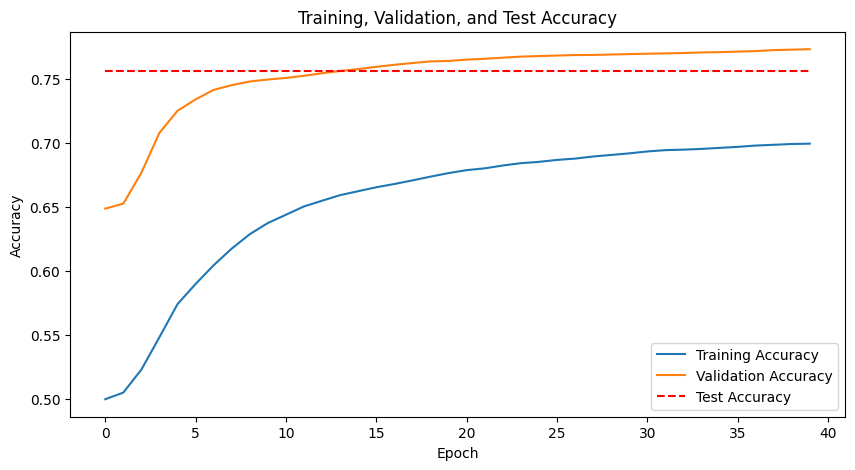

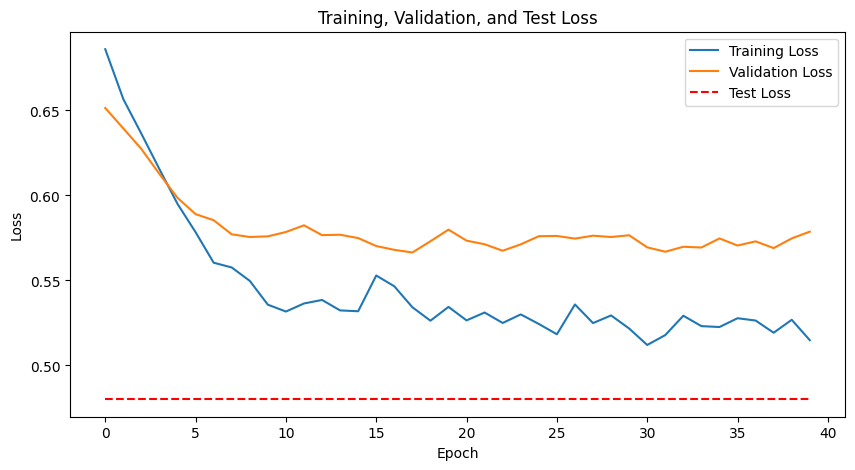

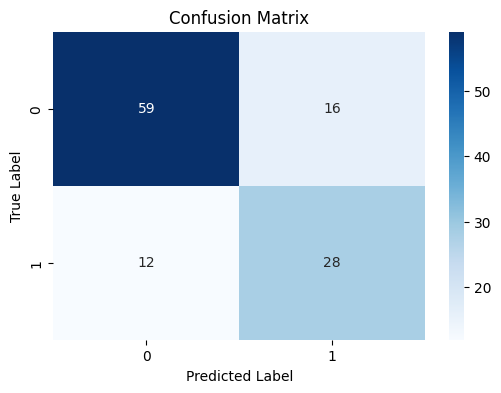

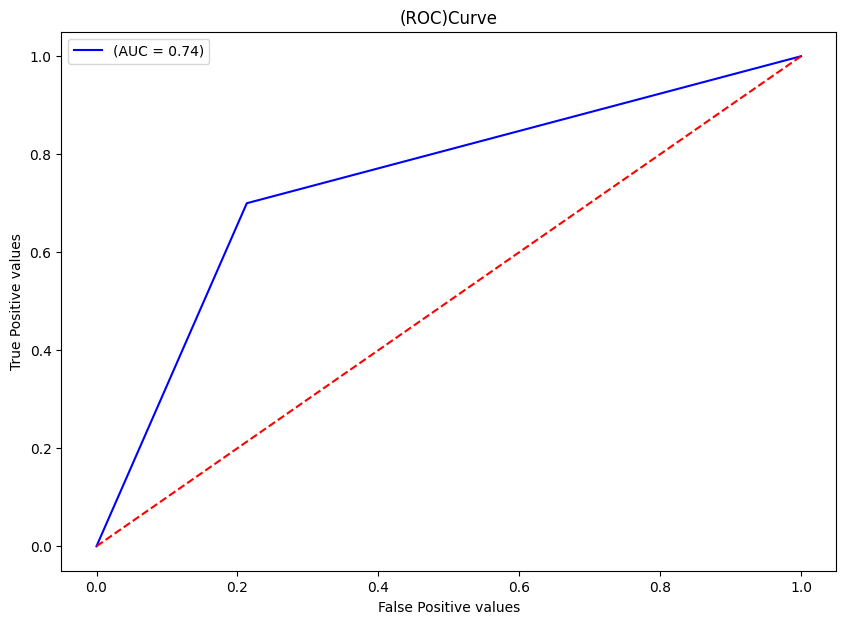

In [33]:
test_accuracies = [accuracy / 100] * epochs
test_losses = [test_loss] * epochs

#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.plot(test_accuracies, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.plot(test_losses, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(test_list, predicted_list)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_list, predicted_list)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='blue', label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('(ROC)Curve')
plt.xlabel('False Positive values')
plt.ylabel('True Positive values')
plt.legend()
plt.show()


Part II: Optimizing NN


Hyperparameter 1 change #1: Changing hidden size from 64 to 128

In [15]:
input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_1 = end_time - start_time  #total training time
print(f"Total Training Time Setup 1: {training_time_setup_1:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_1_1 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 1_1: {accuracy_setup_1_1:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6655, Validation Loss: 0.6435
Epoch [2/40], Training Loss: 0.6122, Validation Loss: 0.6196
Epoch [3/40], Training Loss: 0.5763, Validation Loss: 0.5882
Epoch [4/40], Training Loss: 0.5416, Validation Loss: 0.5729
Epoch [5/40], Training Loss: 0.5463, Validation Loss: 0.5689
Epoch [6/40], Training Loss: 0.5302, Validation Loss: 0.5777
Epoch [7/40], Training Loss: 0.5339, Validation Loss: 0.5792
Epoch [8/40], Training Loss: 0.5378, Validation Loss: 0.5731
Epoch [9/40], Training Loss: 0.5268, Validation Loss: 0.5690
Epoch [10/40], Training Loss: 0.5223, Validation Loss: 0.5679
Epoch [11/40], Training Loss: 0.5238, Validation Loss: 0.5743
Epoch [12/40], Training Loss: 0.5261, Validation Loss: 0.5665
Epoch [13/40], Training Loss: 0.5292, Validation Loss: 0.5755
Epoch [14/40], Training Loss: 0.5266, Validation Loss: 0.5713
Epoch [15/40], Training Loss: 0.5202, Validation Loss: 0.5811
Epoch [16/40], Training Loss: 0.5159, Validation Loss: 0.5780
Epoch [17/40], Tr

hyperparameter 1 change#2: hidden size to 256

In [16]:
input_size = 4  # Number of features
hidden_size1 = 256  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_1 = end_time - start_time  #total training time
print(f"Total Training Time Setup 1: {training_time_setup_1:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_1_2 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 1_2: {accuracy_setup_1_2:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6331, Validation Loss: 0.6125
Epoch [2/40], Training Loss: 0.5447, Validation Loss: 0.5785
Epoch [3/40], Training Loss: 0.5303, Validation Loss: 0.5896
Epoch [4/40], Training Loss: 0.5370, Validation Loss: 0.5729
Epoch [5/40], Training Loss: 0.5283, Validation Loss: 0.5794
Validation loss is 1.1274 from 1.1279
Epoch [6/40], Training Loss: 0.5183, Validation Loss: 0.5637
Validation loss is 1.1260 from 1.1274
Epoch [7/40], Training Loss: 0.5112, Validation Loss: 0.5630
Validation loss is 1.1257 from 1.1260
Epoch [8/40], Training Loss: 0.5164, Validation Loss: 0.5629
Epoch [9/40], Training Loss: 0.5158, Validation Loss: 0.5806
Epoch [10/40], Training Loss: 0.5090, Validation Loss: 0.5773
Validation loss is 1.1148 from 1.1257
Epoch [11/40], Training Loss: 0.5147, Validation Loss: 0.5574
Epoch [12/40], Training Loss: 0.5180, Validation Loss: 0.5615
Epoch [13/40], Training Loss: 0.5137, Validation Loss: 0.5675
Epoch [14/40], Training Loss: 0.5077, Validation Lo

Hyperparameter #1 change 3: hidden size to 512

In [17]:
input_size = 4  # Number of features
hidden_size1 = 512  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 100  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_1 = end_time - start_time  #total training time
print(f"Total Training Time Setup 1: {training_time_setup_1:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_1_3 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 1_3: {accuracy_setup_1_3:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6149, Validation Loss: 0.5675
Epoch [2/40], Training Loss: 0.5502, Validation Loss: 0.5568
Epoch [3/40], Training Loss: 0.5413, Validation Loss: 0.6465
Epoch [4/40], Training Loss: 0.5244, Validation Loss: 0.5713
Epoch [5/40], Training Loss: 0.5212, Validation Loss: 0.5502
Epoch [6/40], Training Loss: 0.5167, Validation Loss: 0.5589
Epoch [7/40], Training Loss: 0.5102, Validation Loss: 0.5923
Epoch [8/40], Training Loss: 0.5061, Validation Loss: 0.5691
Epoch [9/40], Training Loss: 0.5054, Validation Loss: 0.5615
Epoch [10/40], Training Loss: 0.5040, Validation Loss: 0.5802
Epoch [11/40], Training Loss: 0.5095, Validation Loss: 0.5612
Epoch [12/40], Training Loss: 0.4944, Validation Loss: 0.5754
Epoch [13/40], Training Loss: 0.5005, Validation Loss: 0.5694
Epoch [14/40], Training Loss: 0.4950, Validation Loss: 0.5873
Epoch [15/40], Training Loss: 0.4895, Validation Loss: 0.5563
Epoch [16/40], Training Loss: 0.4991, Validation Loss: 0.5706
Epoch [17/40], Tr

Hyperparameter Setup #2: Using hyperparameter setup #1 change #1 as base model, increasing the batch size

In [18]:
input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_2 = end_time - start_time  #total training time
print(f"Total Training Time Setup 2: {training_time_setup_2:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_2_1 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 2_1: {accuracy_setup_2_1:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6685, Validation Loss: 0.6380
Epoch [2/40], Training Loss: 0.6100, Validation Loss: 0.6187
Epoch [3/40], Training Loss: 0.5620, Validation Loss: 0.6041
Epoch [4/40], Training Loss: 0.5519, Validation Loss: 0.5862
Epoch [5/40], Training Loss: 0.5378, Validation Loss: 0.5777
Epoch [6/40], Training Loss: 0.5415, Validation Loss: 0.5708
Epoch [7/40], Training Loss: 0.5370, Validation Loss: 0.5697
Epoch [8/40], Training Loss: 0.5287, Validation Loss: 0.5695
Epoch [9/40], Training Loss: 0.5325, Validation Loss: 0.5717
Epoch [10/40], Training Loss: 0.5304, Validation Loss: 0.5705
Epoch [11/40], Training Loss: 0.5404, Validation Loss: 0.5647
Epoch [12/40], Training Loss: 0.5239, Validation Loss: 0.5603
Epoch [13/40], Training Loss: 0.5258, Validation Loss: 0.5640
Epoch [14/40], Training Loss: 0.5223, Validation Loss: 0.5719
Epoch [15/40], Training Loss: 0.5303, Validation Loss: 0.5602
Epoch [16/40], Training Loss: 0.5285, Validation Loss: 0.5591
Epoch [17/40], Tr

Hyperparameter 2 change#2: change batch size to 2000

In [19]:
input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 2000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_2 = end_time - start_time  #total training time
print(f"Total Training Time Setup 2: {training_time_setup_2:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_2_2 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 2_2: {accuracy_setup_2_2:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6693, Validation Loss: 0.6542
Epoch [2/40], Training Loss: 0.6015, Validation Loss: 0.6128
Epoch [3/40], Training Loss: 0.5657, Validation Loss: 0.5835
Epoch [4/40], Training Loss: 0.5560, Validation Loss: 0.5750
Epoch [5/40], Training Loss: 0.5325, Validation Loss: 0.5676
Epoch [6/40], Training Loss: 0.5398, Validation Loss: 0.5778
Epoch [7/40], Training Loss: 0.5411, Validation Loss: 0.5765
Epoch [8/40], Training Loss: 0.5392, Validation Loss: 0.5729
Epoch [9/40], Training Loss: 0.5290, Validation Loss: 0.5606
Epoch [10/40], Training Loss: 0.5315, Validation Loss: 0.5647
Epoch [11/40], Training Loss: 0.5258, Validation Loss: 0.5730
Epoch [12/40], Training Loss: 0.5270, Validation Loss: 0.5775
Epoch [13/40], Training Loss: 0.5343, Validation Loss: 0.5692
Epoch [14/40], Training Loss: 0.5308, Validation Loss: 0.5667
Epoch [15/40], Training Loss: 0.5182, Validation Loss: 0.5729
Epoch [16/40], Training Loss: 0.5203, Validation Loss: 0.5764
Epoch [17/40], Tr

Hyperparamter 2 change #3: change batch size to 10000

In [20]:
input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 10000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_2 = end_time - start_time  #total training time
print(f"Total Training Time Setup 2: {training_time_setup_2:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_2_3 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 2_3: {accuracy_setup_2_3:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6681, Validation Loss: 0.6220
Epoch [2/40], Training Loss: 0.6051, Validation Loss: 0.5941
Epoch [3/40], Training Loss: 0.5651, Validation Loss: 0.5805
Epoch [4/40], Training Loss: 0.5499, Validation Loss: 0.5681
Epoch [5/40], Training Loss: 0.5302, Validation Loss: 0.5599
Epoch [6/40], Training Loss: 0.5389, Validation Loss: 0.5699
Epoch [7/40], Training Loss: 0.5281, Validation Loss: 0.5712
Epoch [8/40], Training Loss: 0.5220, Validation Loss: 0.5725
Epoch [9/40], Training Loss: 0.5296, Validation Loss: 0.5710
Epoch [10/40], Training Loss: 0.5115, Validation Loss: 0.5736
Epoch [11/40], Training Loss: 0.5270, Validation Loss: 0.5817
Epoch [12/40], Training Loss: 0.5295, Validation Loss: 0.5744
Epoch [13/40], Training Loss: 0.5293, Validation Loss: 0.5779
Epoch [14/40], Training Loss: 0.5304, Validation Loss: 0.5674
Epoch [15/40], Training Loss: 0.5262, Validation Loss: 0.5723
Epoch [16/40], Training Loss: 0.5161, Validation Loss: 0.5738
Epoch [17/40], Tr

Hyperparameter Setup #3: Similarly using setup #2 change #1 as base and added two more hidden layers

In [21]:
class CustomNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1, output_size,dropout):
    super(CustomNeuralNetwork, self).__init__()
    # Input layer
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu1 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #1
    self.fc2 = nn.Linear(hidden_size1, hidden_size1)
    self.relu2 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #2
    self.fc3 = nn.Linear(hidden_size1, hidden_size1)
    self.relu3 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout3 = nn.Dropout(dropout) # adding the dropout layer

    # Hidden layer #3
    self.fc4 = nn.Linear(hidden_size1, hidden_size1)
    self.relu4 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout4 = nn.Dropout(dropout) # adding the dropout layer

    # Output layer
    self.fc5 = nn.Linear(hidden_size1, output_size)
    self.sigmoid = nn.Sigmoid()  # Binary classification output

  def forward(self, x):
    output1 = self.fc1(x)
    output1 = self.relu1(output1)
    output1 = self.dropout(output1)

    output1 = self.fc2(output1)
    output2 = self.relu2(output1)
    output2 = self.dropout(output2)

    output2 = self.fc3(output2)
    output3 = self.relu3(output2)
    output3 = self.dropout3(output3)

    output3 = self.fc4(output3)
    output4 = self.relu4(output3)
    output4 = self.dropout4(output4)

    output4 = self.fc5(output4)
    output5 = self.sigmoid(output4)

    return output5

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 2000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_3 = end_time - start_time  #total training time
print(f"Total Training Time Setup 3: {training_time_setup_3:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_3_1 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 3_1: {accuracy_setup_3_1:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6900, Validation Loss: 0.6902
Epoch [2/40], Training Loss: 0.6692, Validation Loss: 0.6726
Epoch [3/40], Training Loss: 0.6333, Validation Loss: 0.6656
Epoch [4/40], Training Loss: 0.5865, Validation Loss: 0.6340
Epoch [5/40], Training Loss: 0.5624, Validation Loss: 0.5825
Epoch [6/40], Training Loss: 0.5412, Validation Loss: 0.6140
Epoch [7/40], Training Loss: 0.5452, Validation Loss: 0.6038
Epoch [8/40], Training Loss: 0.5522, Validation Loss: 0.5806
Epoch [9/40], Training Loss: 0.5462, Validation Loss: 0.5746
Epoch [10/40], Training Loss: 0.5431, Validation Loss: 0.5722
Epoch [11/40], Training Loss: 0.5420, Validation Loss: 0.5644
Epoch [12/40], Training Loss: 0.5386, Validation Loss: 0.5700
Epoch [13/40], Training Loss: 0.5275, Validation Loss: 0.5738
Epoch [14/40], Training Loss: 0.5190, Validation Loss: 0.5825
Epoch [15/40], Training Loss: 0.5219, Validation Loss: 0.5628
Epoch [16/40], Training Loss: 0.5365, Validation Loss: 0.5754
Epoch [17/40], Tr

Hyperparameter 3 change #2: adde 3 hidden layers compared to base model

In [22]:
class CustomNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1, output_size,dropout):
    super(CustomNeuralNetwork, self).__init__()
    # Input layer
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu1 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #1
    self.fc2 = nn.Linear(hidden_size1, hidden_size1)
    self.relu2 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #2
    self.fc3 = nn.Linear(hidden_size1, hidden_size1)
    self.relu3 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout3 = nn.Dropout(dropout) # adding the dropout layer

    # Hidden layer #3
    self.fc4 = nn.Linear(hidden_size1, hidden_size1)
    self.relu4 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout4 = nn.Dropout(dropout) # adding the dropout layer

    # Hidden layer #4
    self.fc5 = nn.Linear(hidden_size1, hidden_size1)
    self.relu5 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout5 = nn.Dropout(dropout) # adding the dropout layer

    # Output layer
    self.fc6 = nn.Linear(hidden_size1, output_size)
    self.sigmoid = nn.Sigmoid()  # Binary classification output

  def forward(self, x):
    output1 = self.fc1(x)
    output1 = self.relu1(output1)
    output1 = self.dropout(output1)

    output1 = self.fc2(output1)
    output2 = self.relu2(output1)
    output2 = self.dropout(output2)

    output2 = self.fc3(output2)
    output3 = self.relu3(output2)
    output3 = self.dropout3(output3)

    output3 = self.fc4(output3)
    output4 = self.relu4(output3)
    output4 = self.dropout4(output4)

    output4 = self.fc5(output4)
    output5 = self.relu5(output4)
    output5 = self.dropout5(output5)

    output5 = self.fc6(output5)
    output6 = self.sigmoid(output5)

    return output6

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 2000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_3 = end_time - start_time  #total training time
print(f"Total Training Time Setup 3: {training_time_setup_3:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_3_2 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 3_2: {accuracy_setup_3_2:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6931, Validation Loss: 0.6982
Epoch [2/40], Training Loss: 0.6869, Validation Loss: 0.6889
Epoch [3/40], Training Loss: 0.6692, Validation Loss: 0.6675
Epoch [4/40], Training Loss: 0.6202, Validation Loss: 0.6433
Epoch [5/40], Training Loss: 0.5742, Validation Loss: 0.5994
Epoch [6/40], Training Loss: 0.5623, Validation Loss: 0.5625
Epoch [7/40], Training Loss: 0.5424, Validation Loss: 0.6198
Epoch [8/40], Training Loss: 0.5350, Validation Loss: 0.5860
Epoch [9/40], Training Loss: 0.5409, Validation Loss: 0.5696
Epoch [10/40], Training Loss: 0.5281, Validation Loss: 0.5775
Epoch [11/40], Training Loss: 0.5272, Validation Loss: 0.5988
Epoch [12/40], Training Loss: 0.5312, Validation Loss: 0.5836
Epoch [13/40], Training Loss: 0.5362, Validation Loss: 0.5786
Epoch [14/40], Training Loss: 0.5217, Validation Loss: 0.5830
Epoch [15/40], Training Loss: 0.5280, Validation Loss: 0.5863
Epoch [16/40], Training Loss: 0.5102, Validation Loss: 0.6053
Epoch [17/40], Tr

Hyperparameter 3 change #3: adding only 2 hidden layers

In [23]:
class CustomNeuralNetwork(nn.Module):
  def __init__(self, input_size, hidden_size1, output_size,dropout):
    super(CustomNeuralNetwork, self).__init__()
    # Input layer
    self.fc1 = nn.Linear(input_size, hidden_size1)
    self.relu1 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #1
    self.fc2 = nn.Linear(hidden_size1, hidden_size1)
    self.relu2 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout = nn.Dropout(dropout)

    # Hidden layer #2
    self.fc3 = nn.Linear(hidden_size1, hidden_size1)
    self.relu3 = nn.LeakyReLU(negative_slope=0.01)
    self.dropout3 = nn.Dropout(dropout) # adding the dropout layer

    # Output layer
    self.fc4 = nn.Linear(hidden_size1, output_size)
    self.sigmoid = nn.Sigmoid()  # Binary classification output

  def forward(self, x):
    output1 = self.fc1(x)
    output1 = self.relu1(output1)
    output1 = self.dropout(output1)

    output1 = self.fc2(output1)
    output2 = self.relu2(output1)
    output2 = self.dropout(output2)

    output2 = self.fc3(output2)
    output3 = self.relu3(output2)
    output3 = self.dropout3(output3)

    # output3 = self.fc4(output3)
    # output4 = self.relu4(output3)
    # output4 = self.dropout4(output4)

    output3 = self.fc4(output3)
    output4 = self.sigmoid(output3)

    return output4

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 2000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_3 = end_time - start_time  #total training time
print(f"Total Training Time Setup 3: {training_time_setup_3:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_3_3 = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup 3_3: {accuracy_setup_3_3:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6811, Validation Loss: 0.6665
Epoch [2/40], Training Loss: 0.6419, Validation Loss: 0.6423
Epoch [3/40], Training Loss: 0.5885, Validation Loss: 0.6113
Epoch [4/40], Training Loss: 0.5646, Validation Loss: 0.5782
Epoch [5/40], Training Loss: 0.5457, Validation Loss: 0.5618
Epoch [6/40], Training Loss: 0.5373, Validation Loss: 0.5819
Epoch [7/40], Training Loss: 0.5290, Validation Loss: 0.5940
Epoch [8/40], Training Loss: 0.5315, Validation Loss: 0.5909
Epoch [9/40], Training Loss: 0.5247, Validation Loss: 0.5709
Epoch [10/40], Training Loss: 0.5319, Validation Loss: 0.5632
Epoch [11/40], Training Loss: 0.5330, Validation Loss: 0.5784
Epoch [12/40], Training Loss: 0.5320, Validation Loss: 0.5772
Epoch [13/40], Training Loss: 0.5244, Validation Loss: 0.5602
Epoch [14/40], Training Loss: 0.5268, Validation Loss: 0.5640
Epoch [15/40], Training Loss: 0.5205, Validation Loss: 0.5705
Epoch [16/40], Training Loss: 0.5118, Validation Loss: 0.5799
Epoch [17/40], Tr

### The best out of the three setups was Hyperparameter 2 of Setup #3 changing the batch size to 10000.

Improve the model : Methods to increase training speed, accuracy, etc.

In [48]:
#choose the best accuracy model
base_model_accuracy = max(accuracy_setup_1_1,accuracy_setup_1_2,accuracy_setup_1_3, accuracy_setup_2_1,accuracy_setup_2_2,accuracy_setup_2_3, accuracy_setup_3_1,accuracy_setup_3_2,accuracy_setup_3_3)
print(f'Best Base Model accuracy is: {base_model_accuracy}')

# base_model_time = max(training_time_setup_1, training_time_setup_2, training_time_setup_3)
# print(f'Base Model time is: {base_model_time}')

Best Base Model accuracy is: 77.39130434782608


Improved Model Method #1: Early Stopping, using the Setup #2 as base model.

In [57]:
import copy

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 10000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

# Variables used for Early Stopping
best_loss = float('inf')
counter = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

  # Early stopping method
  if val_loss < best_loss:
    best_loss = val_loss
    best_model_weights = copy.deepcopy(model.state_dict())
    counter = 10  # Reset patience counter
  else:
    counter -= 1
    if counter == 0:
        break

end_time = time.time()
training_time_setup_early_stopping = end_time - start_time  #total training time
print(f"Total Training Time Setup Early Stopping: {training_time_setup_early_stopping:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_early_stopping = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup Early Stopping: {accuracy_setup_early_stopping:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


Epoch [1/40], Training Loss: 0.7561, Validation Loss: 0.6859
Epoch [2/40], Training Loss: 0.6892, Validation Loss: 0.6723
Epoch [3/40], Training Loss: 0.6331, Validation Loss: 0.6580
Epoch [4/40], Training Loss: 0.6062, Validation Loss: 0.6430
Epoch [5/40], Training Loss: 0.5865, Validation Loss: 0.6280
Epoch [6/40], Training Loss: 0.5742, Validation Loss: 0.6139
Epoch [7/40], Training Loss: 0.5695, Validation Loss: 0.6004
Epoch [8/40], Training Loss: 0.5490, Validation Loss: 0.5885
Epoch [9/40], Training Loss: 0.5456, Validation Loss: 0.5777
Epoch [10/40], Training Loss: 0.5553, Validation Loss: 0.5689
Epoch [11/40], Training Loss: 0.5460, Validation Loss: 0.5612
Epoch [12/40], Training Loss: 0.5473, Validation Loss: 0.5548
Epoch [13/40], Training Loss: 0.5331, Validation Loss: 0.5493
Epoch [14/40], Training Loss: 0.5414, Validation Loss: 0.5451
Epoch [15/40], Training Loss: 0.5420, Validation Loss: 0.5420
Epoch [16/40], Training Loss: 0.5210, Validation Loss: 0.5392
Epoch [17/40], Tr

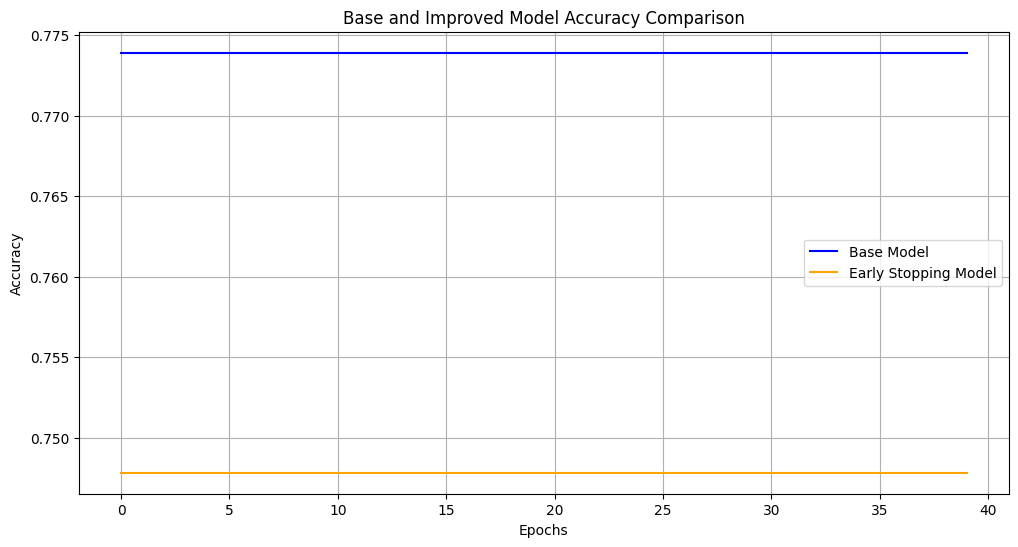

In [58]:
test_accuracies_base_model = [base_model_accuracy/ 100] * epochs
test_accuracies_improved_model = [accuracy_setup_early_stopping / 100] * epochs

plt.figure(figsize=(12,6))
plt.plot(test_accuracies_base_model,label='Base Model', color='blue')
plt.plot(test_accuracies_improved_model, label='Early Stopping Model', color='orange')

plt.title('Base and Improved Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()


Method #2 k-fold

In [60]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 1000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

#Save model weights
save_path = "best_weights_part2_improved_model.pth"
best_validation_loss_kfold = float('inf') #setting loss initially to infinity
best_epoch = 0
best_model_weight = None

train_losses_kfold = []
validation_losses_kfold = []
train_accuracies_kfold = []
validation_accuracies_kfold = []
avg_validation_accuracy_kfold = 0
total_training_labels_kfold = []
total_training_predictions_kfold = []
total_validation_labels_kfold = []
total_validation_predictions_kfold = []
start_time = time.time()
training_epoch_accuracy_kfold = 0
validation_epoch_accuracy_kfold = 0

#using the dataloader for kfold
train_data_loader = data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

validation_data_loader = data.DataLoader(dataset=validation_dataset, batch_size=batch_size, shuffle=False)

#k-fold value
kf = KFold(n_splits=10, shuffle=True)

for train_index, val_index in kf.split(train_dataset):

  train_subset = Subset(train_dataset, train_index)
  val_subset = Subset(train_dataset, val_index)

  train_loader = torch.utils.data.DataLoader(dataset=train_subset,batch_size=batch_size, shuffle=True)

  val_loader = torch.utils.data.DataLoader(dataset=val_subset, batch_size=batch_size, shuffle=False)

  for epoch in range(epochs):
    model.train()  #training mode
    batch_training_loss = 0.0
    correct_train_length = 0
    total_train_length = 0
    for inputs, labels in train_data_loader: #each iteration for a batch size of 100
      outputs = model(inputs)  #runnign our neural netwrok using forward pass function
      loss = criterion(outputs.squeeze(), labels)

      adam_optimizer.zero_grad()
      loss.backward()  #Backpropagation to change weights
      adam_optimizer.step()  #Update weights using adam optimizer
      batch_training_loss += loss.item()

      predicted_train = (outputs.squeeze() > 0.6).float()
      total_training_labels.extend(labels.cpu().numpy())  # Store true labels
      total_training_predictions.extend(predicted_train.cpu().numpy())

    train_losses_kfold.append(batch_training_loss / len(train_data_loader))
    training_epoch_accuracy_kfold = accuracy_score(total_training_labels, total_training_predictions)
    train_accuracies_kfold.append(training_epoch_accuracy_kfold)

    #Validation
    model.eval()  #evaluation mode
    val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
      for val_inputs, val_labels in validation_data_loader:
        val_outputs = model(val_inputs)
        val_loss += criterion(val_outputs.squeeze(), val_labels).item()

        predicted_val = (val_outputs.squeeze() > 0.6).float()
        total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
        total_validation_predictions.extend(predicted_val.cpu().numpy())

    validation_losses_kfold.append(val_loss / len(validation_data_loader))
    validation_epoch_accuracy_kfold = accuracy_score(total_validation_labels, total_validation_predictions)
    validation_accuracies_kfold.append(validation_epoch_accuracy_kfold)

    if val_loss < best_validation_loss_kfold:
      print(f"Validation loss is {val_loss:.4f} from {best_validation_loss_kfold:.4f}")
      best_validation_loss_kfold = val_loss
      best_epoch = epoch + 1
      best_model_weight = model.state_dict()

    print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

if best_model_weight is not None:
  torch.save(best_model_weight, save_path)
  print(f"Best model weights saved to {save_path} from epoch {best_epoch}")

end_time = time.time()
training_time_setup_kfold = end_time - start_time  #total training time
print(f"Total Training Time K-Fold: {training_time_setup_kfold:.2f} seconds")

#Running model on test set
test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list_kfold = []
test_list_kfold = []
test_total_loss_kfold = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list_kfold.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list_kfold.extend(predicted.cpu().numpy())
        test_total_loss_kfold += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_kfold = accuracy_score(test_list_kfold, predicted_list_kfold) * 100
print(f"Test Accuracy Setup K-fold: {accuracy_setup_kfold:.2f}%")
test_loss_kfold = test_total_loss_kfold/len(test_loader)
print(f"Test Loss: {test_loss_kfold:.4f}")

Validation loss is 0.7080 from inf
Epoch [1/40], Training Loss: 0.7665, Validation Loss: 0.7080
Validation loss is 0.6951 from 0.7080
Epoch [2/40], Training Loss: 0.7147, Validation Loss: 0.6951
Validation loss is 0.6818 from 0.6951
Epoch [3/40], Training Loss: 0.6868, Validation Loss: 0.6818
Validation loss is 0.6683 from 0.6818
Epoch [4/40], Training Loss: 0.6446, Validation Loss: 0.6683
Validation loss is 0.6546 from 0.6683
Epoch [5/40], Training Loss: 0.6088, Validation Loss: 0.6546
Validation loss is 0.6407 from 0.6546
Epoch [6/40], Training Loss: 0.5932, Validation Loss: 0.6407
Validation loss is 0.6276 from 0.6407
Epoch [7/40], Training Loss: 0.5790, Validation Loss: 0.6276
Validation loss is 0.6150 from 0.6276
Epoch [8/40], Training Loss: 0.5633, Validation Loss: 0.6150
Validation loss is 0.6036 from 0.6150
Epoch [9/40], Training Loss: 0.5500, Validation Loss: 0.6036
Validation loss is 0.5930 from 0.6036
Epoch [10/40], Training Loss: 0.5426, Validation Loss: 0.5930
Validation l

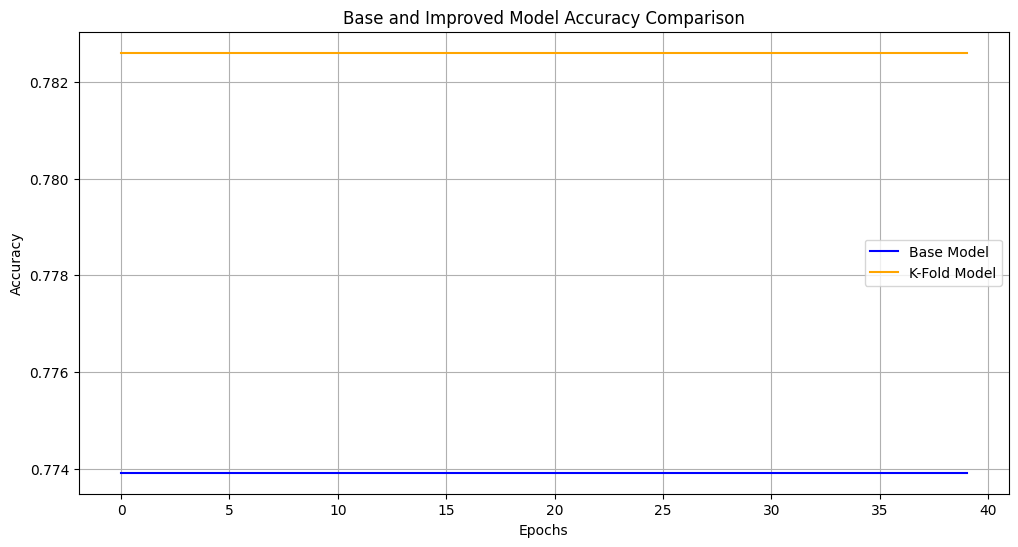

In [61]:
test_accuracies_base_model = [base_model_accuracy / 100] * epochs
test_accuracies_improved_model = [accuracy_setup_kfold / 100] * epochs

plt.figure(figsize=(12,6))
plt.plot(test_accuracies_base_model,label='Base Model', color='blue')
plt.plot(test_accuracies_improved_model, label='K-Fold Model', color='orange')

plt.title('Base and Improved Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

Method #3: Batch Normaization

In [62]:
class CustomNeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size1, output_size,dropout):
        super(CustomNeuralNetwork, self).__init__()
        # Input layer
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.bn1 = nn.BatchNorm1d(hidden_size1)
        self.relu1 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout1 = nn.Dropout(dropout)
        # Hidden layer
        self.fc2 = nn.Linear(hidden_size1, hidden_size1)
        self.bn2 = nn.BatchNorm1d(hidden_size1)
        self.relu2 = nn.LeakyReLU(negative_slope=0.01)
        self.dropout2 = nn.Dropout(dropout)
        # Output layer
        self.fc4 = nn.Linear(hidden_size1, output_size)
        self.sigmoid = nn.Sigmoid()  # Binary classification output

    def forward(self, x):
        output1 = self.bn1(self.fc1(x)) # bn1
        output1 = self.relu1(output1)
        output1 = self.dropout1(output1)
        output1 = self.bn2(self.fc2(output1))  # bn2
        output2 = self.relu2(output1)
        output2 = self.dropout2(output2)
        output3 = self.fc4(output2)
        output4 = self.sigmoid(output3)
        return output4

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 10000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

end_time = time.time()
training_time_setup_batch_norm = end_time - start_time  #total training time
print(f"Total Training Time Setup Batch Normalization: {training_time_setup_batch_norm:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_batch_norm = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup batch Normalization: {accuracy_setup_batch_norm:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")


Epoch [1/40], Training Loss: 0.7310, Validation Loss: 0.6934
Epoch [2/40], Training Loss: 0.6647, Validation Loss: 0.6782
Epoch [3/40], Training Loss: 0.6420, Validation Loss: 0.6625
Epoch [4/40], Training Loss: 0.6041, Validation Loss: 0.6478
Epoch [5/40], Training Loss: 0.5913, Validation Loss: 0.6340
Epoch [6/40], Training Loss: 0.5900, Validation Loss: 0.6210
Epoch [7/40], Training Loss: 0.5583, Validation Loss: 0.6090
Epoch [8/40], Training Loss: 0.5597, Validation Loss: 0.5974
Epoch [9/40], Training Loss: 0.5432, Validation Loss: 0.5872
Epoch [10/40], Training Loss: 0.5488, Validation Loss: 0.5781
Epoch [11/40], Training Loss: 0.5440, Validation Loss: 0.5700
Epoch [12/40], Training Loss: 0.5441, Validation Loss: 0.5629
Epoch [13/40], Training Loss: 0.5425, Validation Loss: 0.5568
Epoch [14/40], Training Loss: 0.5426, Validation Loss: 0.5512
Epoch [15/40], Training Loss: 0.5393, Validation Loss: 0.5466
Epoch [16/40], Training Loss: 0.5455, Validation Loss: 0.5427
Epoch [17/40], Tr

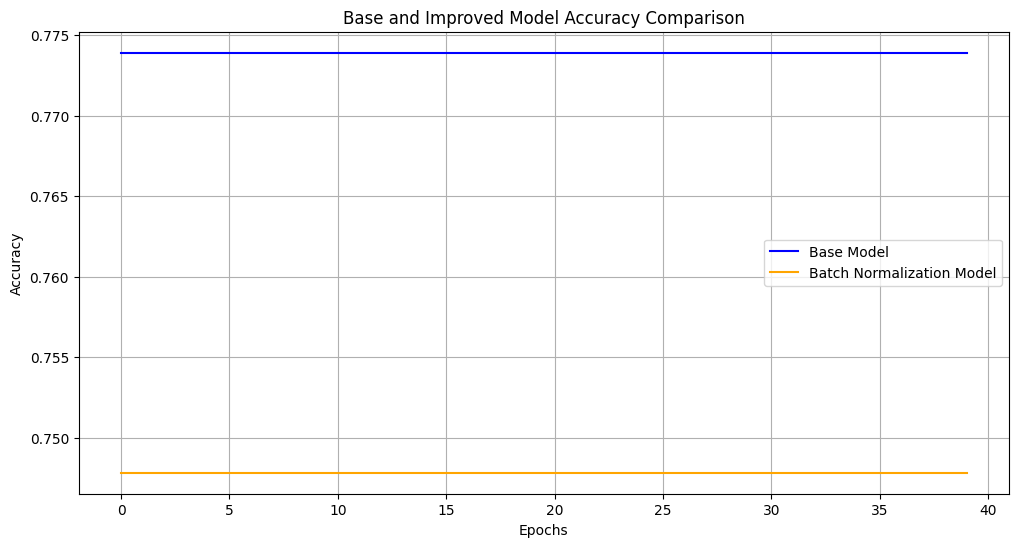

In [63]:
test_accuracies_base_model = [base_model_accuracy / 100] * epochs
test_accuracies_improved_model = [accuracy_setup_batch_norm / 100] * epochs

plt.figure(figsize=(12,6))
plt.plot(test_accuracies_base_model,label='Base Model', color='blue')
plt.plot(test_accuracies_improved_model, label='Batch Normalization Model', color='orange')

plt.title('Base and Improved Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

Method #4: Learning Rate Scheduler

In [64]:
import torch.optim.lr_scheduler as lr_scheduler

input_size = 4  # Number of features
hidden_size1 = 128  # Hidden layer size
output_size = 1  # Binary classification
dropout = 0.4
epochs = 40  # Number of epochs
batch_size = 10000  # Batch size

model = CustomNeuralNetwork(input_size, hidden_size1, output_size,dropout)
criterion = nn.BCELoss()  # Binary Cross Entropy Loss
adam_optimizer = optim.Adam(model.parameters(), lr=0.001) # adam optimizer

start_time = time.time()

#learning rate scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(adam_optimizer, 'min', patience=4)

train_losses = []
validation_losses = []
train_accuracies = []
validation_accuracies = []
avg_validation_accuracy = 0
total_training_labels = []
total_training_predictions = []
total_validation_labels = []
total_validation_predictions = []
start_time = time.time()
training_epoch_accuracy = 0
validation_epoch_accuracy = 0

for epoch in range(epochs):
  model.train()  #training mode
  batch_training_loss = 0.0
  correct_train_length = 0
  total_train_length = 0
  for inputs, labels in train_data_loader: #each iteration for a batch size of 100
    outputs = model(inputs)  #runnign our neural netwrok using forward pass function
    loss = criterion(outputs.squeeze(), labels)

    adam_optimizer.zero_grad()
    loss.backward()  #Backpropagation to change weights
    adam_optimizer.step()  #Update weights using adam optimizer
    batch_training_loss += loss.item()

    predicted_train = (outputs.squeeze() > 0.6).float()
    total_training_labels.extend(labels.cpu().numpy())  # Store true labels
    total_training_predictions.extend(predicted_train.cpu().numpy())

  train_losses.append(batch_training_loss / len(train_data_loader))
  training_epoch_accuracy = accuracy_score(total_training_labels, total_training_predictions)
  train_accuracies.append(training_epoch_accuracy)

  #Validation
  model.eval()  #evaluation mode
  val_loss = 0.0
  correct_val = 0
  total_val = 0
  with torch.no_grad():
    for val_inputs, val_labels in validation_data_loader:
      val_outputs = model(val_inputs)
      val_loss += criterion(val_outputs.squeeze(), val_labels).item()

      predicted_val = (val_outputs.squeeze() > 0.6).float()
      total_validation_labels.extend(val_labels.cpu().numpy())  # Store true labels
      total_validation_predictions.extend(predicted_val.cpu().numpy())

  validation_losses.append(val_loss / len(validation_data_loader))
  validation_epoch_accuracy = accuracy_score(total_validation_labels, total_validation_predictions)
  validation_accuracies.append(validation_epoch_accuracy)

  if val_loss < best_validation_loss:
    print(f"Validation loss is {val_loss:.4f} from {best_validation_loss:.4f}")
    best_validation_loss = val_loss
    best_epoch = epoch + 1
    best_model_weight = model.state_dict()

  print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {batch_training_loss/len(train_data_loader):.4f}, Validation Loss: {val_loss/len(validation_data_loader):.4f}")

  #update the learning rate
  scheduler.step(val_loss)


end_time = time.time()
training_time_setup_lr_scheduler = end_time - start_time  #total training time
print(f"Total Training Time Setup Learning rate scheduler: {training_time_setup_lr_scheduler:.2f} seconds")

# #Running model on test set
# test_dataset = data.TensorDataset(X_test_tensor_value, Y_test_tensor_value)
# test_loader = data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

model.eval()
predicted_list = []
test_list = []
test_total_loss = 0.0
avg_test_accuracy = 0
test_epoch_accuracy = 0
test_accuracies = []
with torch.no_grad():
    for test_inputs, test_labels in test_loader:
        test_outputs = model(test_inputs)
        test_list.extend(test_labels.cpu().numpy())
        predicted = (test_outputs.squeeze() > 0.6).float()
        predicted_list.extend(predicted.cpu().numpy())
        test_total_loss += criterion(test_outputs.squeeze(), test_labels).item()

accuracy_setup_lr_scheduler = accuracy_score(test_list, predicted_list) * 100
print(f"Test Accuracy Setup learning rate scheduler: {accuracy_setup_lr_scheduler:.2f}%")
test_loss = test_total_loss/len(test_loader)
print(f"Test Loss: {test_loss:.4f}")

Epoch [1/40], Training Loss: 0.6837, Validation Loss: 0.6841
Epoch [2/40], Training Loss: 0.6356, Validation Loss: 0.6706
Epoch [3/40], Training Loss: 0.6072, Validation Loss: 0.6571
Epoch [4/40], Training Loss: 0.5955, Validation Loss: 0.6438
Epoch [5/40], Training Loss: 0.5718, Validation Loss: 0.6307
Epoch [6/40], Training Loss: 0.5549, Validation Loss: 0.6184
Epoch [7/40], Training Loss: 0.5540, Validation Loss: 0.6065
Epoch [8/40], Training Loss: 0.5533, Validation Loss: 0.5953
Epoch [9/40], Training Loss: 0.5513, Validation Loss: 0.5847
Epoch [10/40], Training Loss: 0.5497, Validation Loss: 0.5751
Epoch [11/40], Training Loss: 0.5336, Validation Loss: 0.5664
Epoch [12/40], Training Loss: 0.5317, Validation Loss: 0.5584
Epoch [13/40], Training Loss: 0.5370, Validation Loss: 0.5515
Epoch [14/40], Training Loss: 0.5375, Validation Loss: 0.5455
Epoch [15/40], Training Loss: 0.5214, Validation Loss: 0.5405
Epoch [16/40], Training Loss: 0.5328, Validation Loss: 0.5363
Epoch [17/40], Tr

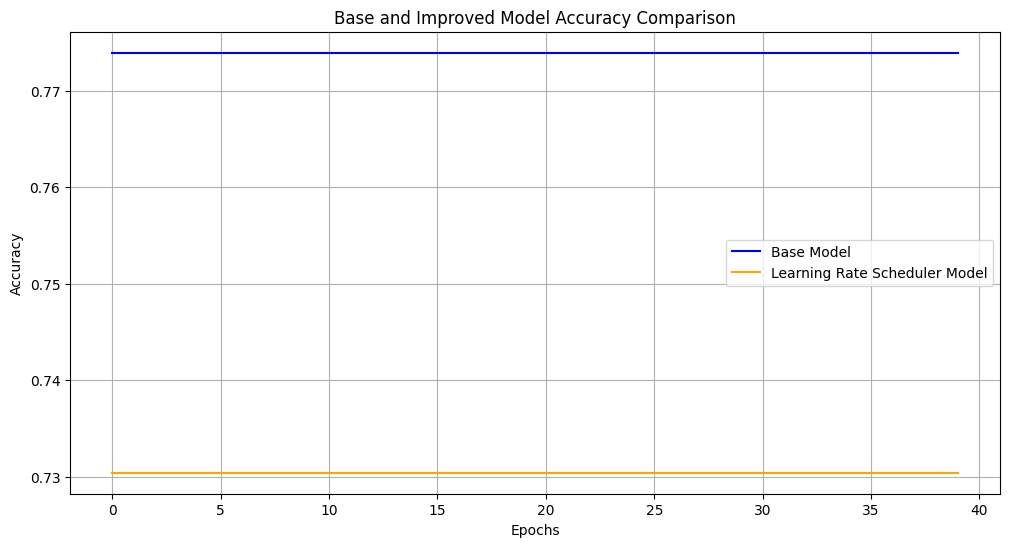

In [66]:
test_accuracies_base_model = [base_model_accuracy / 100] * epochs
test_accuracies_improved_model = [accuracy_setup_lr_scheduler / 100] * epochs

plt.figure(figsize=(12,6))
plt.plot(test_accuracies_base_model,label='Base Model', color='blue')
plt.plot(test_accuracies_improved_model, label='Learning Rate Scheduler Model', color='orange')

plt.title('Base and Improved Model Accuracy Comparison')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

Saved the Best model weights of K-fold model above and now evaluating performance of the improved model

In [67]:
#metrics of the model kfold
precision,recall,f1,_ = precision_recall_fscore_support(test_list_kfold, predicted_list_kfold, average='binary')
#Precision,f1, and recall metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")

Precision: 0.68
Recall: 0.70
F1 Score: 0.69


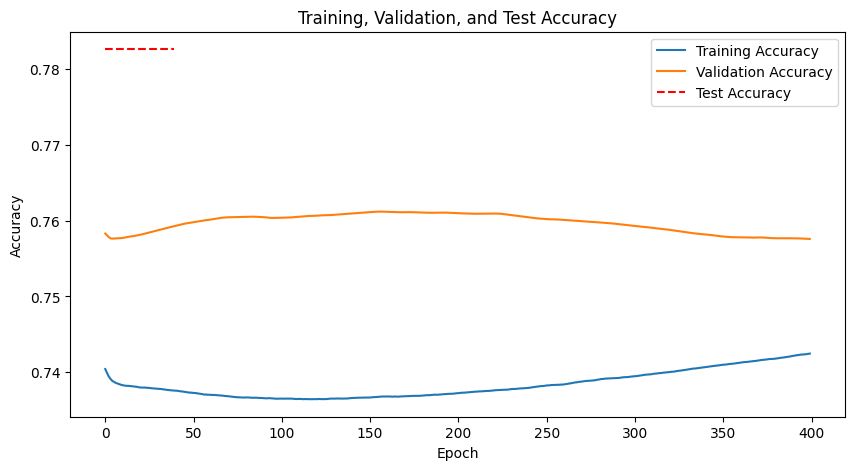

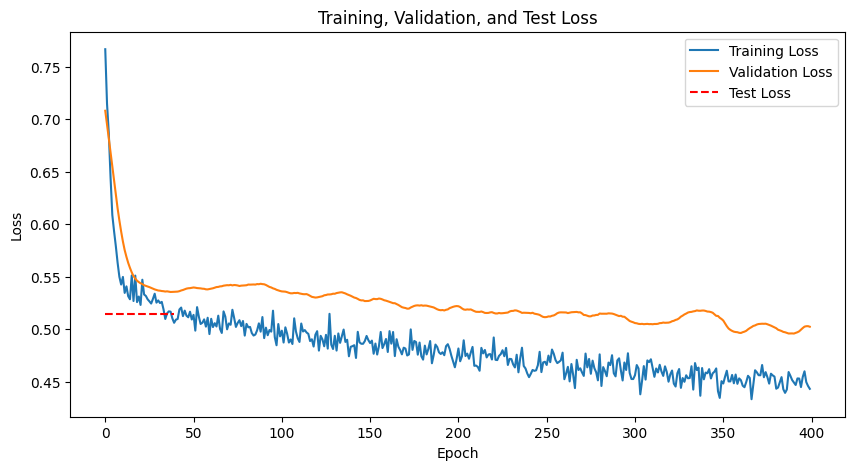

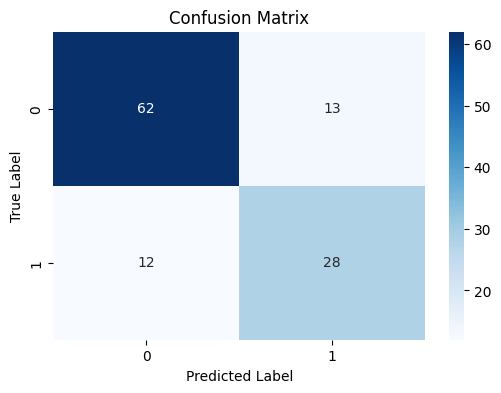

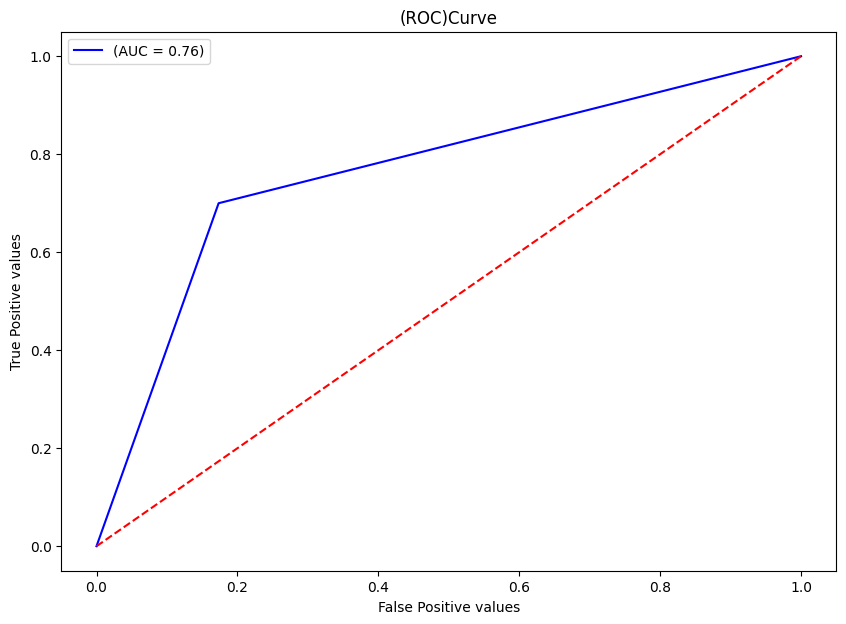

In [71]:
#Save model weights for kfold which has the highest accuracy among the improved models

#plotting graphs for the best model amonng the improved models
test_accuracies_kfold = [accuracy_setup_kfold / 100] * epochs
test_losses_kfold = [test_loss_kfold] * epochs

#Training,Validation and Test Accuracy graph
plt.figure(figsize=(10, 5))
plt.plot(train_accuracies_kfold, label='Training Accuracy')
plt.plot(validation_accuracies_kfold, label='Validation Accuracy')
plt.plot(test_accuracies_kfold, label='Test Accuracy', linestyle='--', color='red')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#Training,Validation and Test Loss graph
plt.figure(figsize=(10, 5))
plt.plot(train_losses_kfold, label='Training Loss')
plt.plot(validation_losses_kfold, label='Validation Loss')
plt.plot(test_losses_kfold, label='Test Loss', linestyle='--', color='red')
plt.title('Training, Validation, and Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#Confusion Matrix
conf_matrix = confusion_matrix(test_list_kfold, predicted_list_kfold)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(test_list_kfold, predicted_list_kfold)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10,7))
plt.plot(fpr, tpr, color='blue', label=f'(AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title('(ROC)Curve')
plt.xlabel('False Positive values')
plt.ylabel('True Positive values')
plt.legend()
plt.show()


# References:
1. https://purnasaigudikandula.medium.com/a-beginner-intro-to-neural-networks-543267bda3c8
2. https://pytorch.org/tutorials/beginner/saving_loading_models.html
3. https://towardsdatascience.com/activation-functions-neural-networks-1cbd9f8d91d6
4. https://medium.com/@juanc.olamendy/understanding-relu-leakyrelu-and-prelu-a-comprehensive-guide-20f2775d3d64
4. https://medium.com/swlh/recall-precision-f1-roc-auc-and-everything-542aedf322b9
5. https://www.geeksforgeeks.org/backpropagation-in-neural-network/
6. https://towardsdatascience.com/understanding-backpropagation-algorithm-7bb3aa2f95fd
